# Analisis Akurasi dan Interpretasi Model XGBoost untuk Pricing Asuransi Kompensasi Pekerja

**By Jonathan Stanley**

Penelitian ini bertujuan untuk mengevaluasi performa dari model XGBoost untuk pricing asuransi kompensasi pekerja. Untuk mendapatkan pemahaman dan pengertian yang lebih lanjut,silahkan dilihat melalui google slides dibawah. https://docs.google.com/presentation/d/1ojoMorsrE_h54eq0wvs4Lm_RFsWJsQzhIRxDrbhbGEM/edit?usp=sharing

In [45]:
#Basic Library
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


#Untuk pengolahan data
from sklearn.model_selection import train_test_split, KFold 
from sklearn.preprocessing import MinMaxScaler

#Model XGboost dan optimisasi
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer


#Evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score





## Data Reading

In [46]:
file_path = 'train.csv'
df = pd.read_csv(file_path,index_col=0)


## Data Understanding

In [47]:
# First 5 rows of the dataframe
df.head().T

ClaimNumber,WC8285054,WC6982224,WC5481426,WC9775968,WC2634037
DateTimeOfAccident,2002-04-09T07:00:00Z,1999-01-07T11:00:00Z,1996-03-25T00:00:00Z,2005-06-22T13:00:00Z,1990-08-29T08:00:00Z
DateReported,2002-07-05T00:00:00Z,1999-01-20T00:00:00Z,1996-04-14T00:00:00Z,2005-07-22T00:00:00Z,1990-09-27T00:00:00Z
Age,48,43,30,41,36
Gender,M,F,M,M,M
MaritalStatus,M,M,U,S,M
DependentChildren,0,0,0,0,0
DependentsOther,0,0,0,0,0
WeeklyWages,500.0,509.34,709.1,555.46,377.1
PartTimeFullTime,F,F,F,F,F
HoursWorkedPerWeek,38.0,37.5,38.0,38.0,38.0


In [48]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
Index: 54000 entries, WC8285054 to WC2542601
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DateTimeOfAccident         54000 non-null  object 
 1   DateReported               54000 non-null  object 
 2   Age                        54000 non-null  int64  
 3   Gender                     54000 non-null  object 
 4   MaritalStatus              53971 non-null  object 
 5   DependentChildren          54000 non-null  int64  
 6   DependentsOther            54000 non-null  int64  
 7   WeeklyWages                54000 non-null  float64
 8   PartTimeFullTime           54000 non-null  object 
 9   HoursWorkedPerWeek         54000 non-null  float64
 10  DaysWorkedPerWeek          54000 non-null  int64  
 11  ClaimDescription           54000 non-null  object 
 12  InitialIncurredCalimsCost  54000 non-null  int64  
 13  UltimateIncurredClaimCost  54000 non-nu

(54000, 14)

In [56]:
df['UltimateIncurredClaimCost'].min()

121.8868054

Variabel target pada penelitian ini adalah 'UltimateIncurredClaimCost' yang merepresentasikan total biaya klaim yang diharapkan, termasuk klaim yang diketahui dan perkiraan klaim masa depan, berdasarkan analisis aktuarial. 

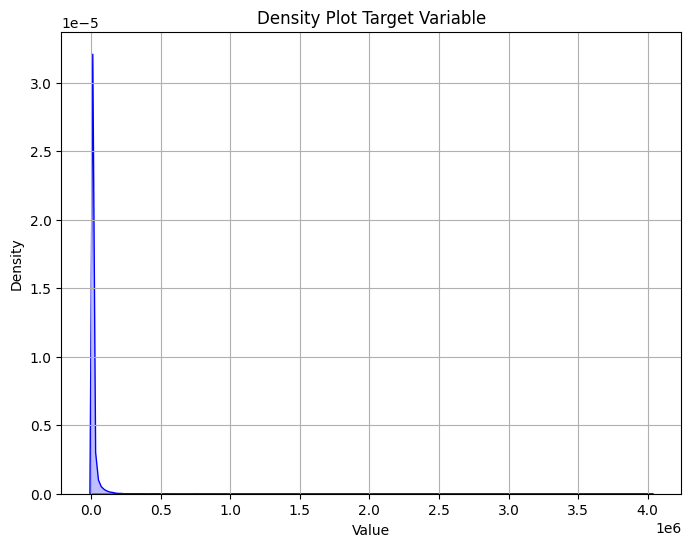

In [57]:
#Density Plot
plt.figure(figsize=(8, 6))
sns.kdeplot(df['UltimateIncurredClaimCost'], color='blue', fill=True)
plt.title('Density Plot Target Variable')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,54000.0,33.842370,12.122165,13.000000,23.000000,32.00000,43.000000,81.000
DependentChildren,54000.0,0.119185,0.517780,0.000000,0.000000,0.00000,0.000000,9.000
DependentsOther,54000.0,0.009944,0.109348,0.000000,0.000000,0.00000,0.000000,5.000
WeeklyWages,54000.0,416.364807,248.638669,1.000000,200.000000,392.20000,500.000000,7497.000
HoursWorkedPerWeek,54000.0,37.735084,12.568704,0.000000,38.000000,38.00000,40.000000,640.000
DaysWorkedPerWeek,54000.0,4.905759,0.552129,1.000000,5.000000,5.00000,5.000000,7.000
InitialIncurredCalimsCost,54000.0,7841.146019,20584.075006,1.000000,700.000000,2000.00000,9500.000000,2000000.000
UltimateIncurredClaimCost,54000.0,11003.369169,33390.991292,121.886805,926.338449,3371.24173,8197.248648,4027135.935


## Data Preprocessing

Datetime features

In [ ]:
#pengubahan tipe fitur DateTime & seleksi data
df['DateTimeOfAccident'] = pd.to_datetime(df['DateTimeOfAccident'])
df['DateReported'] = pd.to_datetime(df['DateReported'])
df['YearReported'] = df['DateReported'].dt.year

#Menggunakan data yang relevan
df = df.loc[(df['YearReported']>=1991)]

df.shape

(45291, 15)

Handling Missing Values

In [ ]:
# Hitung missing values
df.isnull().sum()

DateTimeOfAccident            0
DateReported                  0
Age                           0
Gender                        0
MaritalStatus                28
DependentChildren             0
DependentsOther               0
WeeklyWages                   0
PartTimeFullTime              0
HoursWorkedPerWeek            0
DaysWorkedPerWeek             0
ClaimDescription              0
InitialIncurredCalimsCost     0
UltimateIncurredClaimCost     0
YearReported                  0
dtype: int64

In [ ]:
df[df.isnull().any(axis=1)].T

ClaimNumber,WC3603450,WC3938584,WC9825722,WC4853326,WC3019033,WC7426694,WC3571601,WC3926350,WC8820716,WC4258521,...,WC4125729,WC8409123,WC9017657,WC4600391,WC9746124,WC3163160,WC4597889,WC3975707,WC4830946,WC9834936
DateTimeOfAccident,1992-09-25 14:00:00+00:00,1992-05-07 07:00:00+00:00,2005-07-12 16:00:00+00:00,1994-02-10 22:00:00+00:00,1991-10-21 07:00:00+00:00,2000-10-17 15:00:00+00:00,1992-11-10 12:00:00+00:00,1992-07-10 11:00:00+00:00,2003-07-21 09:00:00+00:00,1993-12-10 17:00:00+00:00,...,1993-03-12 17:00:00+00:00,2002-05-30 13:00:00+00:00,2003-03-21 12:00:00+00:00,1994-02-16 09:00:00+00:00,2005-01-31 09:00:00+00:00,1991-08-21 12:00:00+00:00,1994-03-10 08:00:00+00:00,1993-02-15 13:00:00+00:00,1994-04-11 12:00:00+00:00,2005-01-12 09:00:00+00:00
DateReported,1992-10-09 00:00:00+00:00,1992-05-23 00:00:00+00:00,2005-10-27 00:00:00+00:00,1994-03-02 00:00:00+00:00,1991-10-29 00:00:00+00:00,2000-11-09 00:00:00+00:00,1992-11-26 00:00:00+00:00,1992-09-03 00:00:00+00:00,2003-07-28 00:00:00+00:00,1994-01-17 00:00:00+00:00,...,1993-04-15 00:00:00+00:00,2002-10-23 00:00:00+00:00,2003-05-05 00:00:00+00:00,1994-03-03 00:00:00+00:00,2005-02-16 00:00:00+00:00,1991-08-25 00:00:00+00:00,1994-03-30 00:00:00+00:00,1993-05-12 00:00:00+00:00,1994-10-05 00:00:00+00:00,2005-01-27 00:00:00+00:00
Age,53,58,42,40,33,38,47,45,18,20,...,52,33,22,59,55,36,52,39,32,23
Gender,M,F,M,M,M,M,F,M,F,M,...,F,M,M,M,M,M,M,M,M,M
MaritalStatus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DependentChildren,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DependentsOther,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
WeeklyWages,465.4,446.52,500.0,702.5,379.63,784.61,466.56,385.6,500.0,543.66,...,672.6,500.0,473.1,644.4,437.87,350.0,637.9,650.0,836.92,500.0
PartTimeFullTime,F,F,F,F,F,F,F,F,F,F,...,F,F,F,F,F,F,F,F,F,F
HoursWorkedPerWeek,38.0,38.0,40.0,42.0,40.0,56.0,40.0,38.0,40.0,40.0,...,33.0,40.0,40.0,38.0,40.0,38.0,38.0,38.0,38.0,40.0


In [ ]:
#Analisa column dengan missing value
df.groupby(df['MaritalStatus'])['UltimateIncurredClaimCost'].agg(['mean','median','count'])

,mean,median,count
MaritalStatus,,,
M,13028.654077,4522.489306,18654
S,9857.401085,2486.967424,21926
U,17466.998886,6469.310541,4683


'MartialStatus' memiliki value : (M)arried, (S)ingle, (U)nknown.

In [ ]:
# Mengisi missing values dengan status U = Unknown
df['MaritalStatus']= df['MaritalStatus'].fillna('U')

In [ ]:
#Mengecek ulang apakah masih ada missing value
df.isna().any().any()

False

Feature Engineering

In [ ]:
#pengubahan tipe fitur DateTime

df['DateTimeOfAccident'] = pd.to_numeric(df['DateTimeOfAccident'])
df['DateReported'] = pd.to_numeric(df['DateReported'])

#pemilihan dan rekayasa fitur
df['ReportingDelay'] = (df['DateReported'] - df['DateTimeOfAccident'])
df.drop(columns=['ClaimDescription'], inplace=True)

In [ ]:
#penghapusan unknown value

df.dropna(inplace=True)
df = df.loc[(df['Gender'] != 'U')&(df['MaritalStatus'] != 'U')]

In [ ]:
#penghapusan data dengan nilai fitur tidak realistis
df = df.loc[(df['HoursWorkedPerWeek'] <= 168)&(df['HoursWorkedPerWeek']>0)&
            (df['ReportingDelay']>=0)]
df.shape

(40525, 15)

Outliers

In [ ]:
# Mencari nilai yang ekstrim dari variabel target
vars = ['UltimateIncurredClaimCost']
print(df[vars].sort_values(by='UltimateIncurredClaimCost', ascending=False).head(8))

             UltimateIncurredClaimCost
ClaimNumber                           
WC9916019                 4.027136e+06
WC4540054                 8.657706e+05
WC8981820                 7.684851e+05
WC9789765                 7.414980e+05
WC7286241                 7.137841e+05
WC7977652                 6.086504e+05
WC9540190                 5.869128e+05
WC9879169                 5.584090e+05


In [ ]:
#Membatasi outlier dimana data memiliki nilai yang sangat ekstrim
df.loc[df['UltimateIncurredClaimCost'] > 1000000, 'UltimateIncurredClaimCost'] = 1000000. * 1.000


## Data Transformation

### One Hot Encoding

In [ ]:
#One Hot Encoding 
category = pd.get_dummies(df[['Gender','MaritalStatus','PartTimeFullTime']], 
                          drop_first=True)
#Target variabel
label = df[['UltimateIncurredClaimCost']]

df.drop(columns=['DateReported','Gender','MaritalStatus','PartTimeFullTime',
                 'UltimateIncurredClaimCost','YearReported'], inplace=True)
df = pd.concat([df, category], axis=1)

### Min Max Scaler (Normalisasi)

In [ ]:
#MinMaxScaler
scaler = MinMaxScaler()
df[df.columns] = scaler.fit_transform(df)
df

,DateTimeOfAccident,Age,DependentChildren,DependentsOther,WeeklyWages,HoursWorkedPerWeek,DaysWorkedPerWeek,InitialIncurredCalimsCost,ReportingDelay,Gender_M,MaritalStatus_S,PartTimeFullTime_P
ClaimNumber,,,,,,,,,,,,
WC8285054,0.778189,0.522388,0.0,0.0,0.066569,0.221557,0.666667,0.000750,0.079263,1.0,0.0,0.0
WC6982224,0.584759,0.447761,0.0,0.0,0.067815,0.218563,0.666667,0.002750,0.011236,0.0,0.0,0.0
WC9775968,0.968755,0.417910,0.0,0.0,0.073967,0.221557,0.666667,0.007500,0.026752,1.0,1.0,0.0
WC6828422,0.611628,0.552239,0.0,0.0,0.026547,0.221557,0.666667,0.000250,0.072690,1.0,0.0,0.0
WC8058150,0.734248,0.388060,0.0,0.0,0.026547,0.221557,0.666667,0.000250,0.008484,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
WC7006507,0.616188,0.328358,0.0,0.0,0.026547,0.233533,0.666667,0.007500,0.544141,1.0,0.0,0.0
WC9370727,0.919122,0.283582,0.0,0.0,0.066569,0.221557,0.666667,0.000500,0.015555,0.0,1.0,0.0
WC8396269,0.781296,0.104478,0.0,0.0,0.066569,0.233533,0.666667,0.000500,0.116793,0.0,1.0,0.0


In [ ]:
label

,UltimateIncurredClaimCost
ClaimNumber,
WC8285054,4748.203388
WC6982224,6326.285819
WC9775968,17786.487170
WC6828422,598.762315
WC8058150,279.068178
...,...
WC7006507,11847.081780
WC9370727,480.493308
WC8396269,755.735319


In [ ]:
df.head().T

ClaimNumber,WC8285054,WC6982224,WC9775968,WC6828422,WC8058150
DateTimeOfAccident,0.778189,0.584759,0.968755,0.611628,0.734248
Age,0.522388,0.447761,0.417910,0.552239,0.388060
DependentChildren,0.000000,0.000000,0.000000,0.000000,0.000000
DependentsOther,0.000000,0.000000,0.000000,0.000000,0.000000
WeeklyWages,0.066569,0.067815,0.073967,0.026547,0.026547
HoursWorkedPerWeek,0.221557,0.218563,0.221557,0.221557,0.221557
DaysWorkedPerWeek,0.666667,0.666667,0.666667,0.666667,0.666667
InitialIncurredCalimsCost,0.000750,0.002750,0.007500,0.000250,0.000250
ReportingDelay,0.079263,0.011236,0.026752,0.072690,0.008484
Gender_M,1.000000,0.000000,1.000000,1.000000,1.000000


## Data Modelling

### Data Splitting

Data training dan testing akan dibagi dengan perbandingan 70:30, dimana 70% barisan pertama termasuk dalam training set, dan 30% baris terakhir termasuk dalam testing set

In [ ]:
X = df
y = label.values


In [ ]:
# Mendefinisikan Jangkauan searching untuk hyperparameter
params = {
    "alpha": Real(0.01, 10, prior='log-uniform'),
    "learning_rate": Real(0.01, 0.5, prior='uniform'),
    "max_depth": Integer(2, 10),
    "n_estimators": Integer(50, 1000),
    "min_child_weight": Real(1, 10),
    "subsample": Real(0.5, 1.0, prior='uniform'),
    "colsample_bytree": Real(0.1, 1.0, prior='uniform'),
    "gamma": Real(0, 10)
}




In [ ]:
results = []
y_preds_xg = [] 
models = []
max_iteration = 5

for iteration in range(max_iteration):
    print(f"Iteration {iteration+1}")

    # Splitting data training dan testing dengan perbandingan 70:30.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=iteration)
    
    # Model XGBoost
    xg_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=36)

    # k-fold Cross Validation
    k = 4
    kf = KFold(n_splits=k, shuffle=True, random_state=0)
    
    # Bayes Search 
    bayes_search = BayesSearchCV(
        estimator=xg_reg,
        search_spaces=params,
        cv=kf,
        n_jobs=-1,  
        verbose= 0,
        n_iter= 30,  
    )
    # Fitting
    bayes_search.fit(X_train, y_train)

    # Best Hyperparameter
    best_params = bayes_search.best_params_

    #  XGBoost regressor with the best hyperparameters
    best_xg = xgb.XGBRegressor(objective='reg:squarederror', random_state=36, **best_params)

    best_xg.set_params(early_stopping_rounds=10, eval_metric='rmse')
    best_xg.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    # Model Prediction
    y_pred_xg = best_xg.predict(X_test)
    y_preds_xg.append(y_pred_xg)  

    # Metrik Evaluasi Umum
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_xg))
    mae = mean_absolute_error(y_test, y_pred_xg)
    r2 = r2_score(y_test, y_pred_xg)
    
    # Store result
    result = {
        'Iteration': iteration+1,
        'Best_Params': best_params,
        'RMSE': rmse,
        'MAE': mae,
        'R^2' : r2
    }
    models.append(best_xg) 
    results.append(result)

xg_results_df = pd.DataFrame(results)
# Save result
xg_results_df.to_csv('xgb_hyperparameter_results.csv', index=False)
        
# Save y_pred for each iteration
for i, y_pred_xg in enumerate(y_preds_xg, start=1):
    filename = f'y_pred_xg_{i}.pkl'
    joblib.dump(y_pred_xg, filename)

# Save models for each iteration
for i, model in enumerate(models, start=1):
    filename = f'xg_model_iteration{i}.sav'
    joblib.dump(model, filename)
        


Iteration 1
[0]	validation_0-rmse:32970.84213
[1]	validation_0-rmse:32922.25528
[2]	validation_0-rmse:32810.41808
[3]	validation_0-rmse:32697.31636
[4]	validation_0-rmse:32587.15766
[5]	validation_0-rmse:32475.52425
[6]	validation_0-rmse:32367.22889
[7]	validation_0-rmse:32261.56106
[8]	validation_0-rmse:32217.62540
[9]	validation_0-rmse:32114.08138
[10]	validation_0-rmse:32080.53084
[11]	validation_0-rmse:32035.24351
[12]	validation_0-rmse:31993.33170
[13]	validation_0-rmse:31953.92798
[14]	validation_0-rmse:31909.29340
[15]	validation_0-rmse:31811.83267
[16]	validation_0-rmse:31716.02009
[17]	validation_0-rmse:31677.69137
[18]	validation_0-rmse:31647.91809
[19]	validation_0-rmse:31610.84372
[20]	validation_0-rmse:31574.77659
[21]	validation_0-rmse:31539.80151
[22]	validation_0-rmse:31502.54144
[23]	validation_0-rmse:31411.59045
[24]	validation_0-rmse:31323.73970
[25]	validation_0-rmse:31291.69657
[26]	validation_0-rmse:31256.92726
[27]	validation_0-rmse:31169.70426
[28]	validation_0-

In [ ]:
xg_results_df

,Iteration,Best_Params,RMSE,MAE,R^2
0,1,"{'alpha': 0.01, 'colsample_bytree': 0.48468848...",25946.052800,7871.796938,0.299565
1,2,"{'alpha': 0.024115483389037493, 'colsample_byt...",21813.539557,7255.773974,0.354384
2,3,"{'alpha': 0.01, 'colsample_bytree': 0.40928609...",24397.756988,7816.153519,0.298777
3,4,"{'alpha': 0.01, 'colsample_bytree': 0.47150213...",24337.290015,7738.853452,0.325162
4,5,"{'alpha': 0.2638371927727053, 'colsample_bytre...",22995.741178,7155.304712,0.330485


In [38]:
print('Average RMSE:',xg_results_df['RMSE'].mean())
print('Average MAE:',xg_results_df['MAE'].mean())
print('Average R^2:',xg_results_df['R^2'].mean())

Average RMSE: 23898.076107523902
Average MAE: 7567.576519149926
Average R^2: 0.3216743991722145


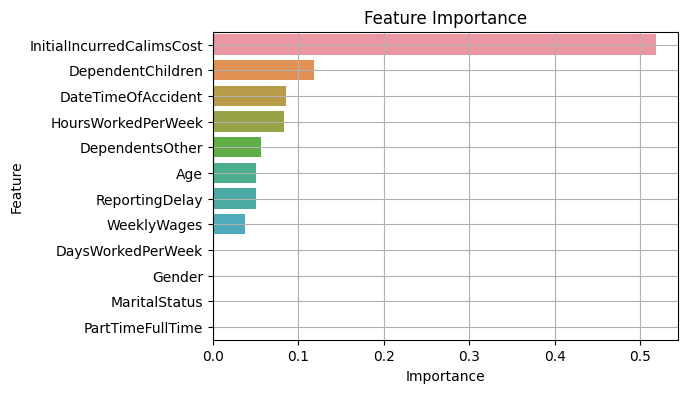

In [41]:
# Feature importance
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Menggabungkan one-hot-encoded variables dengan nama yang sama
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.split('_').str[0]
feature_importance_df = feature_importance_df.groupby('Feature', as_index=False)['Importance'].sum()

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Membuat plot bar
plt.figure(figsize=(6, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()